In [10]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
) 
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

c:\Users\singh\Let's Gooooo\Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


"I was created by OpenAI, and I am a language model based on the GPT-3.5 architecture. I can understand and generate human-like text based on the input I receive. My design is aimed at assisting with a wide range of topics, answering questions, providing explanations, and engaging in conversation. If you have any specific questions or topics you'd like to discuss, feel free to ask!"

### LLM Iterative Workflow

In [11]:
from pydantic import BaseModel , Field
from typing import Annotated , Literal

class SmEval(BaseModel):
    eval_result : Annotated[Literal['approved' , "need_impro"] , Field(description="based on the post quality it it will, rsult in weather this is fine or need improvemnts." , examples=['approved' , "need_impro"])]
    eval_feedback : Annotated[str , Field(description="A short descption what doesn;t work with the post, such that it didn't get approval")]
    

In [12]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict , Literal

class SmState(TypedDict):
    topic : str
    post : str
    eval : Literal['approved' , "need_impro"]
    feedback : str
    iter_ : int
    max_iter : int = 3
    
def get_post(state:SmState)->SmState:
    prompt = PromptTemplate(
        template="You're a LinkedIN writter, Insprired from the modern posts writing, you have to write a 100-150 word ppst on the topic of {topic}. Make no mistake and factual Error",
        input_variables=['topic']
    )
    
    # Creating Chains
    post_chain = prompt | llm_openai | parser
    # Invoke chain
    post = post_chain.invoke({'topic': state['topic']})
    state['post'] = post
    return state

def evaluate_post(state:SmState)->SmState:
    prompt = PromptTemplate(
        template="You're a social media Expert Based on that {post} , classify the post into two categeory, is this good enough or it need improvements, if yes then what type of improvemnts.",
        input_variables=['post']
    )
    
    llm_gemini_eval_struc = llm_gemini.with_structured_output(SmEval)
    
    eval_chain = prompt | llm_gemini_eval_struc
    
    eval_results = eval_chain.invoke({"post" : state['post']})
    state['eval'] = eval_results.eval_result
    state['feedback'] = eval_results.eval_feedback
    return state

def optimise_post(state:SmState)->SmState:
    promt = PromptTemplate(
        template="You're a Linkdin expert, based on the feedback that i recvived : \n {feedback} \nmake optimise my post such that it doesn't have problems as menentoned on my original post, post : \n{post}",
        input_variables=[ 'feedback', 'post']
    )
    
    optmise_chain = promt | llm_openai | parser
    
    new_post = optmise_chain.invoke({"feedback" : state['feedback'] , "post" : state['post']})
    state['post'] = new_post
    return state

In [13]:
def route_eval(state:SmState)->SmState:
    if state['eval'] == 'approved' or state['iter_'] > state['max_iter']:
        return 'approved'
    else:
        return "need_impro"


In [14]:
graph = StateGraph(SmState)

graph.add_node("generate" , get_post)
graph.add_node("optimise" , optimise_post)
graph.add_node("evalution" , evaluate_post)

graph.add_edge(START , 'generate')
graph.add_edge('generate' , 'evalution')
graph.add_conditional_edges('evalution' , route_eval , {"approved" : END , "need_impro" : "optimise"})
graph.add_edge("optimise" , "evalution")

iter_workflow = graph.compile()

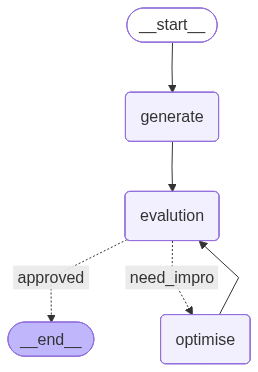

In [8]:
from IPython.display import Image
Image(iter_workflow.get_graph().draw_mermaid_png())

In [17]:
start_state = {"topic" : "How a 3 year old, will write it's first linkedIn post" , "iter_" : 0 , "max_iter" : 3 }

final_state = iter_workflow.invoke(start_state)

In [18]:
final_state

{'topic': "How a 3 year old, will write it's first linkedIn post",
 'post': 'Here’s a revised version of your LinkedIn post that maintains professionalism and offers tangible value to your audience:\n\n---\n\n🌟 **Embracing Early Learning: The Foundation of Professional Growth** 🌟\n\nHello, LinkedIn community! 👋\n\nToday, I’m excited to share my thoughts on the importance of building a strong foundation for future success in our careers. While I may be at the beginning of my journey, I recognize that the skills we develop early in our lives can significantly impact our professional paths.\n\nHere are a few key skills that I believe are vital for long-term success:\n\n1. **Effective Communication**: Expressing ideas clearly and listening actively fosters collaboration and innovation in any workplace.\n\n2. **Relationship Building**: Connections matter! Networking and forming meaningful relationships can open doors to opportunities and enhance our professional lives.\n\n3. **Curiosity and